## MARBL diagnostics for ocean history files: 

### BHIST run with 4p2z ecosystem

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
from cartopy.util import add_cyclic_point
from IPython.display import Image
import utils
import pandas as pd
import pop_tools

import tools

### Define latest year and get the CESM data

In [2]:
start_yr = 1880
num_years = 10
endyr = start_yr + num_years 
case = 'b.e21.BHIST.f09_g17.ccisens-reference.001'

In [3]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/campaign/cgd/tss/lawrence/ccisensarchive//{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 1880 !
doing simulation year 1881 !
doing simulation year 1882 !
doing simulation year 1883 !
doing simulation year 1884 !
doing simulation year 1885 !
doing simulation year 1886 !
doing simulation year 1887 !
doing simulation year 1888 !
doing simulation year 1889 !


In [4]:
cesm_mon_ds=xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

### Keep only the variables we need

In [5]:
variables = ['sp_Fe_lim_surf','sp_P_lim_surf','sp_N_lim_surf',
             'diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf',
             'diat_SiO3_lim_surf','diaz_P_lim_surf',
             'diaz_Fe_lim_surf','photoC_TOT_zint','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint',
             'cocco_Fe_lim_surf','cocco_C_lim_surf','cocco_N_lim_surf',
             'cocco_P_lim_surf','CaCO3_PROD_zint','SiO2_PROD','POC_FLUX_100m',
             'coccoCaCO3','diatC', 'coccoC','spC','diazC','SALT',
             'PO4','Fe','NO3','SiO3','ALK','photoC_TOT_zint_100m',
            'microzooC','mesozooC','x_graze_microzoo_zint','x_graze_mesozoo_zint',
            'IFRAC','diaz_Nfix',
            'spChl','diatChl','diazChl','coccoChl'] 
coords = {'x':'TLONG','y':'TLAT'}

In [6]:
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keep_vars])

### Make the annual mean

In [7]:
cesm_ann_ds=cesm_mon_ds.mean(dim='time')

### Turn the monthly ds into a climatology

In [8]:
cesm_mon_ds["time"] = cesm_mon_ds.time_bound.compute().mean(dim="d2")

In [9]:
cesm_mon_ds = cesm_mon_ds.groupby('time.month').mean('time')

In [10]:
ds_grid = pop_tools.get_grid('POP_gx1v7')


lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
depths=ds_grid.z_t * 0.01
area_m=area * 1.e-4
dz_m=ds_grid.dz * 0.01

#### World Ocean Atlas 2013

In [11]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [12]:
ds_woa['z_t'] = cesm_ann_ds.z_t

In [13]:
NO3_diff = cesm_ann_ds.NO3 - ds_woa.NO3
PO4_diff = cesm_ann_ds.PO4 - ds_woa.PO4
SiO3_diff = cesm_ann_ds.SiO3 - ds_woa.SiO3

In [14]:
rmse_global = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})

In [15]:
#help(esmlab.statistics)
rmse_global['NO3']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.NO3, ds_woa.NO3, dim=['nlat', 'nlon'], weights=area)
rmse_global['PO4']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.PO4, ds_woa.PO4, dim=['nlat', 'nlon'], weights=area)
rmse_global['SiO3']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.SiO3, ds_woa.SiO3, dim=['nlat', 'nlon'], weights=area)

In [16]:
rmse_global.PO4.values

array([0.20048737, 0.20340918, 0.21263863, 0.22541785, 0.23764112,
       0.24737756, 0.25702949, 0.26671849, 0.27847507, 0.28881516,
       0.29372866, 0.29707553, 0.30368701, 0.30221116, 0.30395184,
       0.30208697, 0.2971895 , 0.2961959 , 0.29124218, 0.29071908,
       0.28888988, 0.29080264, 0.28692862, 0.2854691 , 0.28583143,
       0.28634312, 0.28654003, 0.28500513, 0.28200778, 0.28077148,
       0.27714528, 0.27009583, 0.2614381 , 0.25262844, 0.24907897,
       0.24726996, 0.25442214, 0.26997762, 0.28732613, 0.31582055,
       0.34676516, 0.37854298, 0.40517014, 0.41735876, 0.42629836,
       0.42541681, 0.419928  , 0.411888  , 0.4006966 , 0.39192157,
       0.38437683, 0.38532423, 0.39271845, 0.40573461, 0.42623147,
       0.44957007, 0.47483979, 0.50438668, 0.54426489, 0.5868709 ])

In [17]:
rmse_global.NO3.values

array([ 3.37852045,  3.56320614,  3.72013452,  3.93190439,  4.1148153 ,
        4.25124684,  4.419956  ,  4.61027653,  4.74342182,  4.8911025 ,
        4.92617715,  4.99026261,  5.1046474 ,  5.0939922 ,  5.14698867,
        5.17526705,  5.18221223,  5.25127662,  5.22164764,  5.26429508,
        5.37021646,  5.58394552,  5.60354092,  5.68595163,  5.92316704,
        6.21978583,  6.61857604,  7.13046933,  7.6071898 ,  8.17527647,
        8.68821477,  9.22513009,  9.71236463, 10.26046897, 10.83185854,
       11.118888  , 11.22110009, 11.03610417, 10.38676057,  9.49311084,
        8.27876575,  7.027437  ,  5.8194281 ,  4.91979752,  4.44368682,
        4.40957128,  4.62312228,  4.87376462,  5.06885253,  5.19129815,
        5.26839908,  5.32341234,  5.40949193,  5.58546885,  5.87007099,
        6.15734909,  6.44065791,  6.77027714,  7.21904562,  7.76648253])

In [18]:
rmse_global.SiO3.values

array([ 9.69871433,  9.90139434,  9.82694474,  9.83108704,  9.88968208,
        9.95804096, 10.22868971, 10.45276363, 10.77291723, 10.97136307,
       11.03693058, 11.0940902 , 11.09621089, 10.97229831, 10.87072139,
       10.74461427, 10.60604731, 10.53497076, 10.34643694, 10.26243087,
       10.13025534, 10.09680899,  9.85585695,  9.67189599,  9.56365942,
        9.47856578,  9.43843287,  9.39461386,  9.36096593,  9.31413103,
        9.35495133,  9.51390364,  9.68715205, 10.07282296, 10.5651803 ,
       11.08865991, 11.42235539, 11.56625771, 11.97568312, 12.00550491,
       11.92453403, 12.15428775, 12.1843872 , 13.00619223, 13.59368081,
       14.25720682, 15.21518511, 16.62717779, 18.43485711, 20.62865338,
       23.08494003, 25.69590465, 28.52297084, 31.61987817, 34.93147263,
       38.20518353, 41.30941428, 44.69911018, 49.16417542, 55.37958202])

#### Surface nutrients

In [19]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

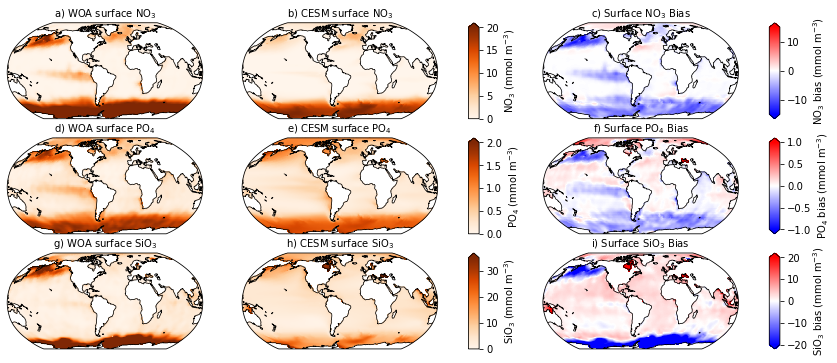

In [20]:
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(nrows=3, ncols=6, width_ratios=(1, 1, 0.05, 0.05, 1, 0.05))

prj = ccrs.Robinson(central_longitude=305.0)

ax_no3_woa = plt.subplot(gs[0, 0], projection=prj)
ax_no3_cesm = plt.subplot(gs[0, 1], projection=prj)
cax_no3 = plt.subplot(gs[0, 2])
ax_no3_diff = plt.subplot(gs[0, 4], projection=prj)
cax_no3_diff = plt.subplot(gs[0, 5])

ax_po4_woa = plt.subplot(gs[1, 0], projection=prj)
ax_po4_cesm = plt.subplot(gs[1, 1], projection=prj)
cax_po4 = plt.subplot(gs[1, 2])
ax_po4_diff = plt.subplot(gs[1, 4], projection=prj)
cax_po4_diff = plt.subplot(gs[1, 5])

ax_si_woa = plt.subplot(gs[2, 0], projection=prj)
ax_si_cesm = plt.subplot(gs[2, 1], projection=prj)
cax_si = plt.subplot(gs[2, 2])
ax_si_diff = plt.subplot(gs[2, 4], projection=prj)
cax_si_diff = plt.subplot(gs[2, 5])


### NO3 row
ax_no3_woa.set_title('a) WOA surface NO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_woa.NO3.isel(z_t=0))
pc1=ax_no3_woa.pcolormesh(lon, lat,field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_no3_woa.coastlines('110m',linewidth=0.75)

ax_no3_cesm.set_title('b) CESM surface NO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, cesm_ann_ds.NO3.isel(z_t=0))
pc1=ax_no3_cesm.pcolormesh(lon, lat,field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_no3_cesm.coastlines('110m',linewidth=0.75)

cb_no3 = plt.colorbar(pc1, cax=cax_no3,extend='max', 
                      label='NO$_3$ (mmol m$^{-3}$)')

ax_no3_diff.set_title('c) Surface NO$_3$ Bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, NO3_diff.isel(z_t=0))
pc1=ax_no3_diff.pcolormesh(lon, lat,field, vmin=-15, vmax=15, cmap='bwr',
                 transform=ccrs.PlateCarree())
ax_no3_diff.coastlines('110m',linewidth=0.75)

cb_no3_diff = plt.colorbar(pc1, cax=cax_no3_diff,extend='both', 
                      label='NO$_3$ bias (mmol m$^{-3}$)')


### PO4 row
ax_po4_woa.set_title('d) WOA surface PO$_4$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_woa.PO4.isel(z_t=0))
pc1=ax_po4_woa.pcolormesh(lon, lat,field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_po4_woa.coastlines('110m',linewidth=0.75)

ax_po4_cesm.set_title('e) CESM surface PO$_4$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, cesm_ann_ds.PO4.isel(z_t=0))
pc1=ax_po4_cesm.pcolormesh(lon, lat, field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_po4_cesm.coastlines('110m',linewidth=0.75)

cb_po4 = plt.colorbar(pc1, cax=cax_po4,extend='max', 
                      label='PO$_4$ (mmol m$^{-3}$)')

ax_po4_diff.set_title('f) Surface PO$_4$ Bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, PO4_diff.isel(z_t=0))
pc1=ax_po4_diff.pcolormesh(lon, lat,field, vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
ax_po4_diff.coastlines('110m',linewidth=0.75)

cb_po4_diff = plt.colorbar(pc1, cax=cax_po4_diff,extend='both', 
                      label='PO$_4$ bias (mmol m$^{-3}$)')


### SiO3 row
ax_si_woa.set_title('g) WOA surface SiO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_woa.SiO3.isel(z_t=0))
pc1=ax_si_woa.pcolormesh(lon, lat,field, vmin=0, vmax=35, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_si_woa.coastlines('110m',linewidth=0.75)

ax_si_cesm.set_title('h) CESM surface SiO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, cesm_ann_ds.SiO3.isel(z_t=0))
pc1=ax_si_cesm.pcolormesh(lon, lat, field, vmin=0, vmax=35, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_si_cesm.coastlines('110m',linewidth=0.75)

cb_si = plt.colorbar(pc1, cax=cax_si,extend='max', 
                      label='SiO$_3$ (mmol m$^{-3}$)')

ax_si_diff.set_title('i) Surface SiO$_3$ Bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, SiO3_diff.isel(z_t=0))
pc1=ax_si_diff.pcolormesh(lon, lat, field, vmin=-20, vmax=20, cmap='bwr',
                 transform=ccrs.PlateCarree())
ax_si_diff.coastlines('110m',linewidth=0.75)

cb_si_diff = plt.colorbar(pc1, cax=cax_si_diff,extend='both', 
                      label='SiO$_3$ bias (mmol m$^{-3}$)')

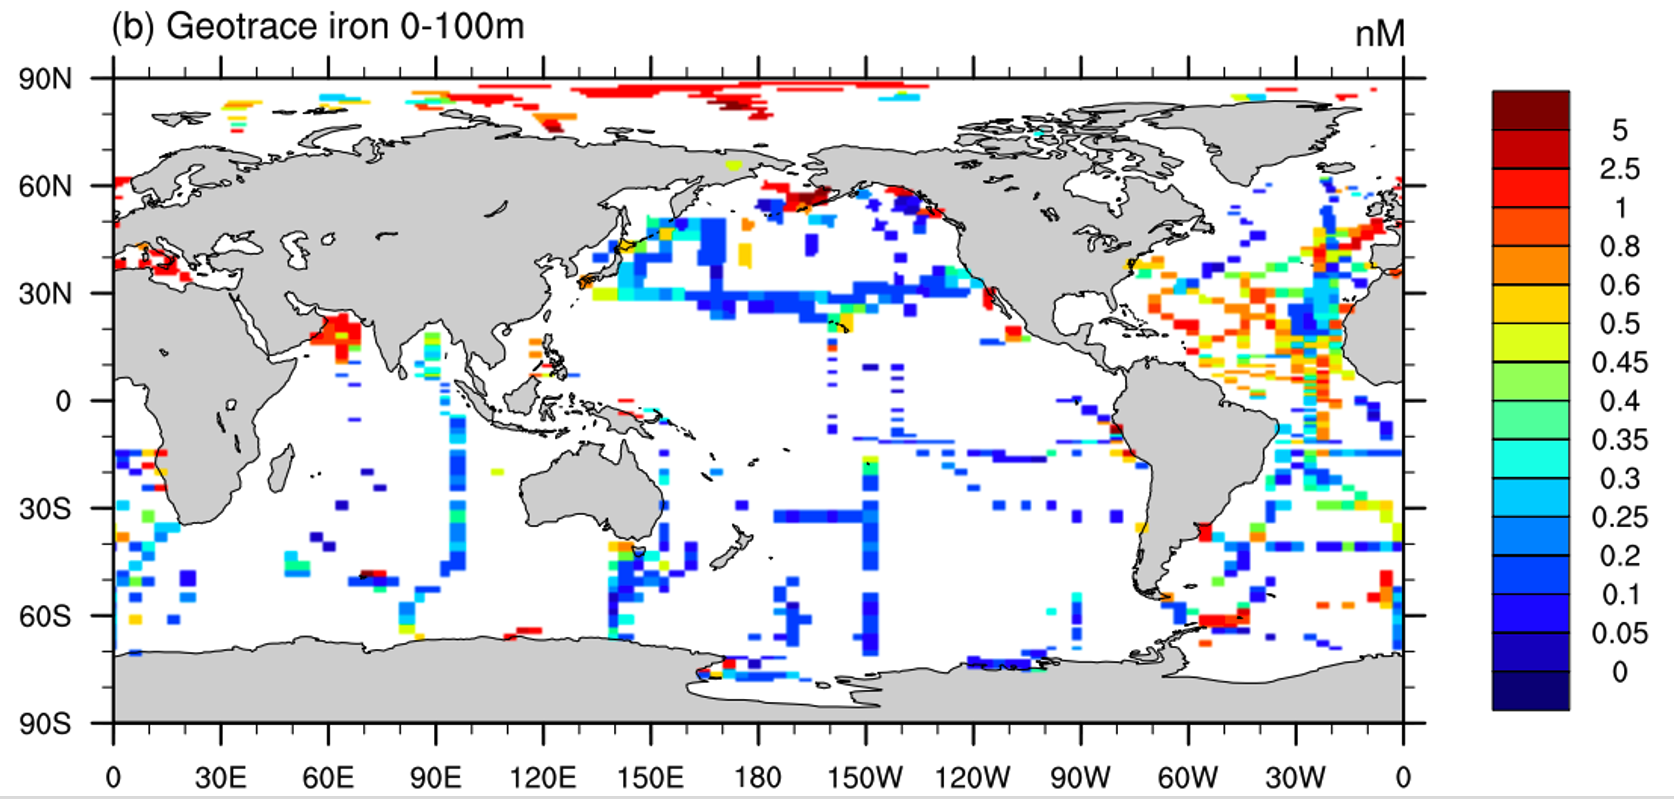

In [21]:
Image(filename='/glade/work/kristenk/Fe_obs/Fe_concs.png')
# df.obs_stream.add_model_field(ds_grid.REGION_MASK, method='nearest')
# df

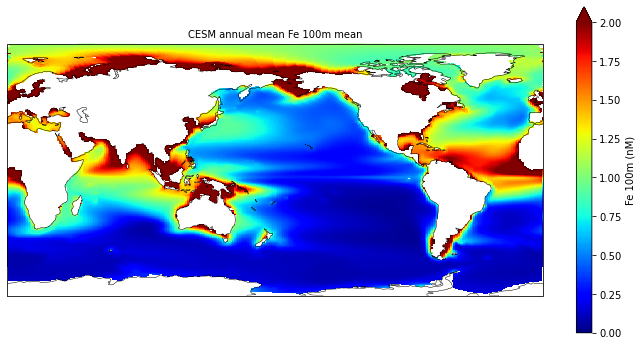

In [22]:
fig = plt.figure(figsize=(12,6))

#---- CESM panel
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(central_longitude=180))
#ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree(central_longitude=0))
ax.coastlines('110m',linewidth=0.5)
ax.set_title('CESM annual mean Fe 100m mean', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.Fe.isel(z_t=slice(0,10)).mean(dim='z_t')*1e3)
pc1=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=2, cmap='jet',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Fe 100m (nM)')

# #---- OBS panel
# ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
# ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
# ax.coastlines('10m',linewidth=0.5)
# ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
# lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_woa.NO3.isel(z_t=0))
# pc2=ax.pcolormesh(lon, lat, 
#                  field, vmin=0, vmax=20, cmap='Oranges',
#                  transform=ccrs.PlateCarree())
# cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

### Global nutrient profiles

In [23]:
ds_glb = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})
ds_glb['NO3']= esmlab.weighted_mean(cesm_ann_ds['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb['PO4']= esmlab.weighted_mean(cesm_ann_ds['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb['SiO3']= esmlab.weighted_mean(cesm_ann_ds['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()

In [24]:
ds_glb_woa = xr.Dataset({v: cesm_ann_ds[v] for v in ['z_t']})
ds_glb_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=area, dim=['nlat', 'nlon']).compute()
ds_glb_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'], weights=area, dim=['nlat', 'nlon']).compute()

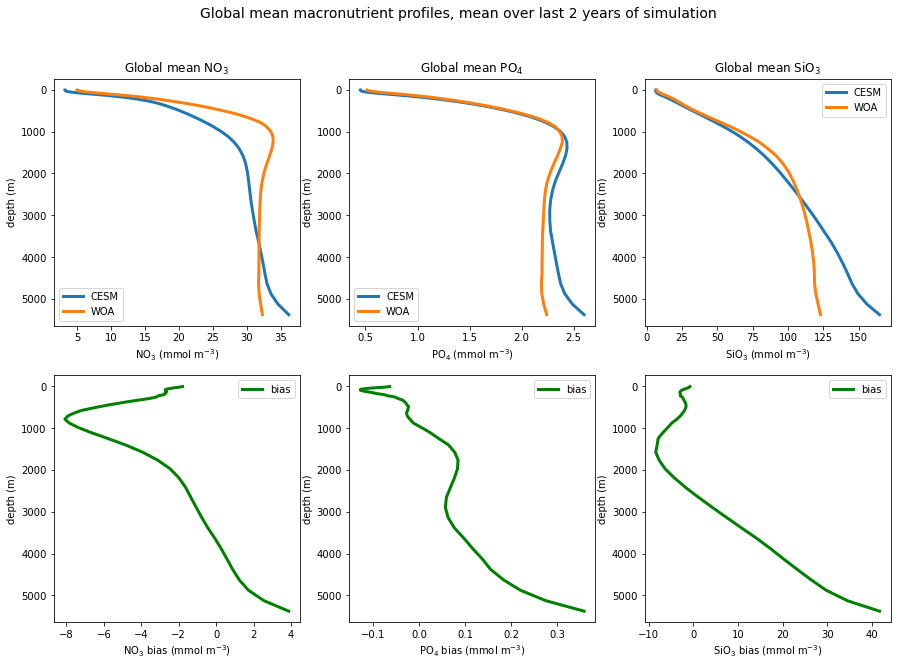

In [25]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Global mean macronutrient profiles, mean over last 2 years of simulation', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb['NO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['NO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb['PO4'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['PO4'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb['SiO3'].values, depths, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['SiO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



### Phytoplankton nutrient limitation at surface

In [26]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)
# 3 = C (only for cocco)

limarray_sp=xr.concat((cesm_ann_ds.sp_P_lim_surf, cesm_ann_ds.sp_Fe_lim_surf,cesm_ann_ds.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((cesm_ann_ds.diat_P_lim_surf, cesm_ann_ds.diat_Fe_lim_surf, cesm_ann_ds.diat_N_lim_surf, cesm_ann_ds.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((cesm_ann_ds.diaz_P_lim_surf, cesm_ann_ds.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((cesm_ann_ds.cocco_P_lim_surf, cesm_ann_ds.cocco_Fe_lim_surf, cesm_ann_ds.cocco_N_lim_surf, cesm_ann_ds.cocco_C_lim_surf),dim='nutrient')

In [27]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False)
mask = np.isnan(cesm_ann_ds.sp_N_lim_surf.squeeze())

In [28]:
most_lim_sp = most_lim_sp.squeeze()
most_lim_diat = most_lim_diat.squeeze()
most_lim_diaz = most_lim_diaz.squeeze()
most_lim_cocco = most_lim_cocco.squeeze()

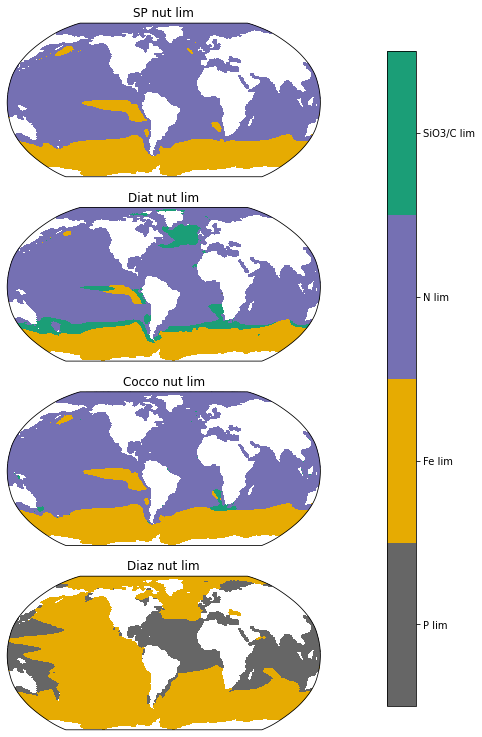

In [29]:
fig = plt.figure(figsize=(8,13))
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diat nut lim', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_diat.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('SP nut lim', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_sp.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Cocco nut lim', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_cocco.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diaz nut lim', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_diaz.where(~mask))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Monthly nutrient limitations

In [30]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)
# 3 = C (only for cocco)

limarray_sp=xr.concat((cesm_mon_ds.sp_P_lim_surf, cesm_mon_ds.sp_Fe_lim_surf,cesm_mon_ds.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((cesm_mon_ds.diat_P_lim_surf, cesm_mon_ds.diat_Fe_lim_surf, cesm_mon_ds.diat_N_lim_surf, cesm_mon_ds.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((cesm_mon_ds.diaz_P_lim_surf, cesm_mon_ds.diaz_Fe_lim_surf),dim='nutrient')
limarray_cocco=xr.concat((cesm_mon_ds.cocco_P_lim_surf, cesm_mon_ds.cocco_Fe_lim_surf, cesm_mon_ds.cocco_N_lim_surf, cesm_mon_ds.cocco_C_lim_surf),dim='nutrient')

In [31]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
most_lim_cocco=limarray_cocco.argmin(dim='nutrient', skipna=False)
mask = np.isnan(cesm_ann_ds.sp_N_lim_surf.squeeze())

In [32]:
cesm_mon_ds

<xarray.Dataset>
Dimensions:                (month: 12, nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t                    (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m               (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * month                  (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/49)
    dz                     (month, z_t) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    TLONG                  (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TLAT                   (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    KMT                    (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    REGION_MASK            (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TAREA                  (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ...                     ...
    diatC                  (month, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
    diazChl                (month, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
    diazC                  (month, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
    coccoChl               (month, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
    coccoC                 (month, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
    coccoCaCO3             (month, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BHIST.f09_g17.ccisens-reference.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2024-03-07 at 04:11:13.1
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

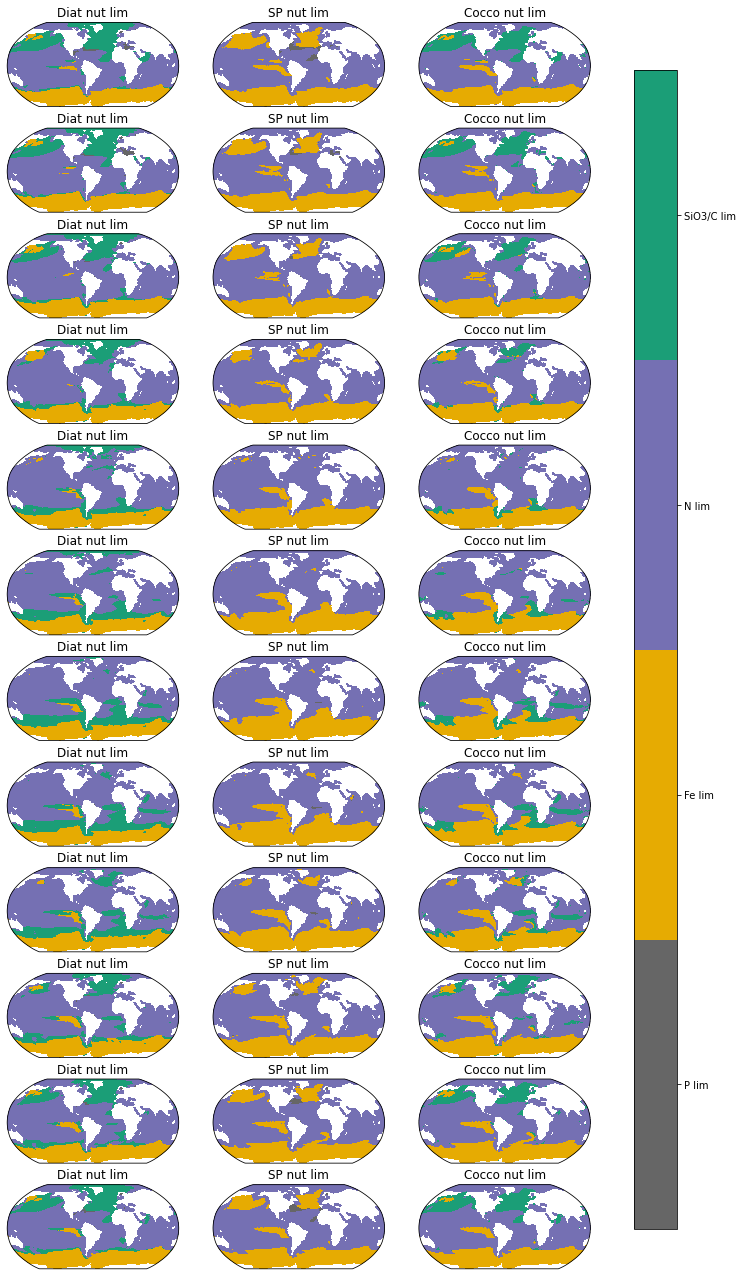

In [33]:
fig = plt.figure(figsize=(12,23))

for row in np.arange(1,13):
    ts=row-1
    
    plot = row*3 - 2
    
    #row 1 Jan
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Diat nut lim', fontsize=12)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_diat.isel(month=ts).where(~mask))
    pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3 - 1
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('SP nut lim', fontsize=12)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_sp.isel(month=ts).where(~mask))
    pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot = row*3
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Cocco nut lim', fontsize=12)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  most_lim_cocco.isel(month=ts).where(~mask))
    pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Look at phyto carbon pools

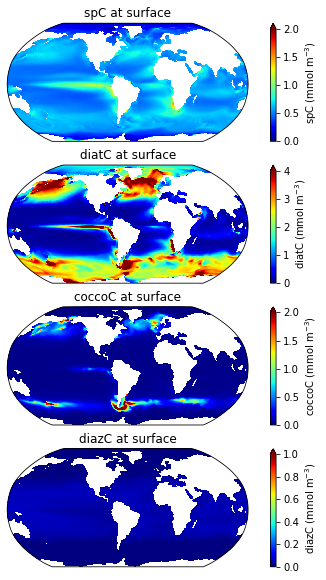

In [34]:
###### 
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.coccoC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.diatC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.spC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.diazC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

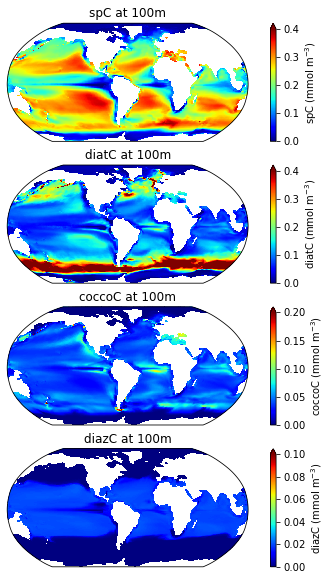

In [35]:
###### 
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at 100m', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.coccoC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at 100m', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.diatC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at 100m', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.spC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at 100m', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.diazC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

### Phytoplankton production maps

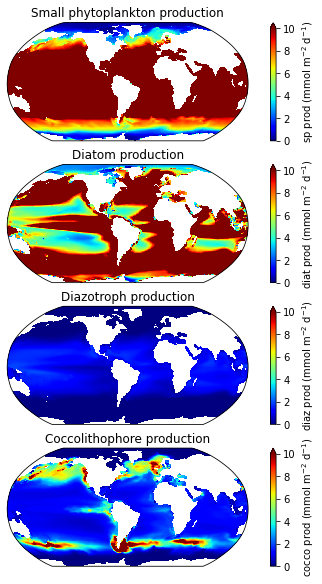

In [36]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small phytoplankton production', fontsize=12)
tmp = cesm_ann_ds.photoC_sp_zint * 864.
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='sp prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diatom production', fontsize=12)
tmp = cesm_ann_ds.photoC_diat_zint * 864.
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diat prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diazotroph production', fontsize=12)
tmp = cesm_ann_ds.photoC_diaz_zint * 864.
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diaz prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Coccolithophore production', fontsize=12)
tmp = cesm_ann_ds.photoC_cocco_zint * 864.
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco prod (mmol m$^{-2}$ d$^{-1}$)')

### Look at percent phytoC

In [37]:
phytoC = cesm_ann_ds.spC + cesm_ann_ds.diatC + cesm_ann_ds.diazC + cesm_ann_ds.coccoC
perc_sp = cesm_ann_ds.spC / (phytoC) * 100.
perc_cocco = cesm_ann_ds.coccoC / (phytoC) * 100.
perc_diat = cesm_ann_ds.diatC / (phytoC) * 100.
perc_diaz = cesm_ann_ds.diazC / (phytoC) * 100.

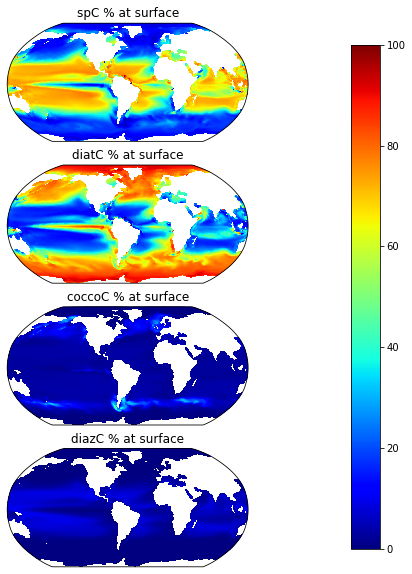

In [38]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_cocco.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_diat.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_sp.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_diaz.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pc, cax=cbar_ax)

### Plot zooC

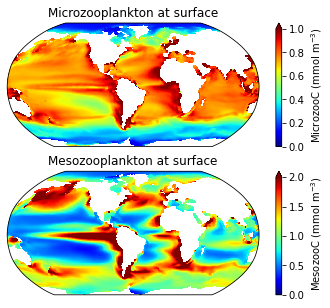

In [39]:
fig = plt.figure(figsize=(6,5))

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.microzooC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='MicrozooC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.mesozooC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='MesozooC (mmol m$^{-3}$)');


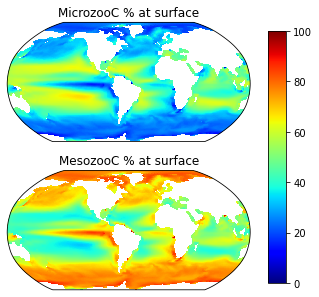

In [40]:
zooC = cesm_ann_ds.microzooC + cesm_ann_ds.mesozooC
perc_microzoo = cesm_ann_ds.microzooC / (zooC) * 100.
perc_mesozoo = cesm_ann_ds.mesozooC / (zooC) * 100.

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MicrozooC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_microzoo.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MesozooC % at surface', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  perc_mesozoo.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pc, cax=cbar_ax);

In [41]:
microzoo_biomass= esmlab.weighted_sum(cesm_ann_ds.microzooC, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
microzoo_biomass = microzoo_biomass * 10. #mmol
microzoo_biomass = microzoo_biomass.sum(dim='z_t_150m')
microzoo_biomass = microzoo_biomass.values * 0.001 * 1.e-15 * 12.011 #Pg C

print('Microzooplankton biomass is estimated at 0.24 Pg C (Buitenhuis et al., 2010). Here it is ', np.round(microzoo_biomass,4), ' Pg C.')


mesozoo_biomass= esmlab.weighted_sum(cesm_ann_ds.mesozooC, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
mesozoo_biomass = mesozoo_biomass * 10. #mmol
mesozoo_biomass = mesozoo_biomass.sum(dim='z_t_150m')
mesozoo_biomass = mesozoo_biomass.values * 0.001 * 1.e-15 * 12.011 #Pg C

print('Mesozooplankton biomass is estimated to be between 0.16 to 0.19 Pg C (Buitenhuis et al., 2006; Moriarty & OBrien, 2013). Here it is ', np.round(mesozoo_biomass,4), ' Pg C.')

Microzooplankton biomass is estimated at 0.24 Pg C (Buitenhuis et al., 2010). Here it is  0.2314  Pg C.
Mesozooplankton biomass is estimated to be between 0.16 to 0.19 Pg C (Buitenhuis et al., 2006; Moriarty & OBrien, 2013). Here it is  0.416  Pg C.


### Plot zooplankton production maps

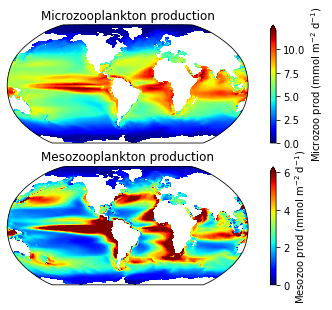

In [42]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton production', fontsize=12)
tmp = cesm_ann_ds.x_graze_microzoo_zint * 864.
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=12,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Microzoo prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Mesozooplankton production', fontsize=12)
tmp = cesm_ann_ds.x_graze_mesozoo_zint * 864.
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=6,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Mesozoo prod (mmol m$^{-2}$ d$^{-1}$)')

### NPP

In [43]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

In [44]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'cocco', 'TOT']]

ds_glb = xr.Dataset()
for v in variables:
    ds_glb[v] = esmlab.statistics.weighted_sum(cesm_ann_ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_glb[v].attrs = cesm_ann_ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()
ds_glb

<xarray.Dataset>
Dimensions:            ()
Data variables:
    photoC_diat_zint   float64 22.47
    photoC_sp_zint     float64 28.36
    photoC_diaz_zint   float64 1.125
    photoC_cocco_zint  float64 3.236
    photoC_TOT_zint    float64 55.19

In [45]:
print('diatom NPP is ', np.round((ds_glb['photoC_diat_zint']/ds_glb['photoC_TOT_zint']*100.).values,2),'% of total NPP.')

diatom NPP is  40.71 % of total NPP.


### Chlorophyll comparison

In [46]:
chl_file = '/glade/work/kristenk/satellite_data/Chl_cumulative_mean/A20021852020182.L3m_CU_CHL_chlor_a_9km.nc'
ds_chl = xr.open_dataset(chl_file, decode_times=False)
#units are mg/m3
tot_chl = cesm_ann_ds.spChl.isel(z_t_150m=0) + cesm_ann_ds.diatChl.isel(z_t_150m=0) + cesm_ann_ds.coccoChl.isel(z_t_150m=0) + cesm_ann_ds.diazChl.isel(z_t_150m=0)

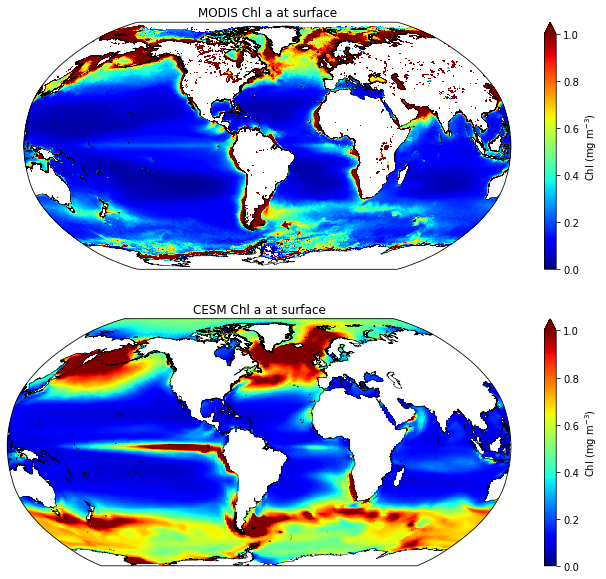

In [47]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MODIS Chl a at surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_chl.lon.values, ds_chl.lat.values, ds_chl.chlor_a, cmap='jet',
                 vmin=0,vmax=1,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM Chl a at surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tot_chl)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',
                 vmin=0,vmax=1,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Chl (mg m$^{-3}$)')


### Zooplankton production (zoo grazing - zoo respiration)
#### Should be ~25% of NPP

In [48]:
variables = [f'x_graze_{zoo}_zint' for zoo in ['microzoo', 'mesozoo']]

ds_zooglb = xr.Dataset()
for v in variables:
    ds_zooglb[v] = esmlab.statistics.weighted_sum(cesm_ann_ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_zooglb[v].attrs = cesm_ann_ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_zooglb[v] = ds_zooglb[v] * nmols_to_PgCyr        
    ds_zooglb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_zooglb = ds_zooglb.compute()
ds_zooglb

<xarray.Dataset>
Dimensions:                ()
Data variables:
    x_graze_microzoo_zint  float64 9.038
    x_graze_mesozoo_zint   float64 4.781

In [49]:
## calculate % zoo prod of NPP 
npp_tot=ds_glb.photoC_TOT_zint.values
zoo_prod=ds_zooglb.x_graze_microzoo_zint.values + ds_zooglb.x_graze_mesozoo_zint.values
print('• Zooplankton production is ', (zoo_prod/npp_tot * 100.), '% of NPP.')
## calculate % microzooplankton (zoo1) prod of total zoo prod
micro_prod=ds_zooglb.x_graze_microzoo_zint.values
print('• Microzooplankton production is ', (micro_prod/zoo_prod * 100.), '% of total zooplankton production.')
print('• Microzooplankton production is ', (micro_prod/npp_tot * 100.), '% of NPP.')

• Zooplankton production is  25.039660251827577 % of NPP.
• Microzooplankton production is  65.4051705885298 % of total zooplankton production.
• Microzooplankton production is  16.37723250249612 % of NPP.


### Z-ratio (Stock & Dunne, 2010)

In [50]:
file='/glade/work/kristenk/z-ratio/z_ratio_POPgrid.nc'
ds_zratio=xr.open_dataset(file,decode_times=False,decode_coords=False)

In [51]:
z_ratio = cesm_ann_ds.x_graze_mesozoo_zint / cesm_ann_ds.photoC_TOT_zint

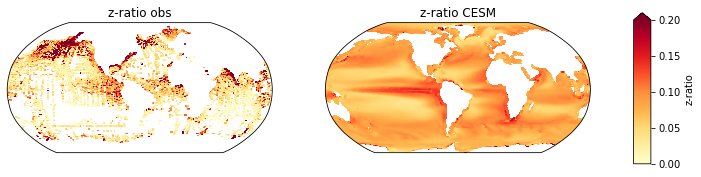

In [52]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio obs', fontsize=12)
tmp = ds_zratio.z_ratio
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='YlOrRd',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio CESM', fontsize=12)
tmp = z_ratio
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='YlOrRd',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='z-ratio')

### MAREDAT Micozooplankton/zoo1+zoo2 comparison

In [53]:
file = '/glade/work/kristenk/MAREDAT/microzooplankton/mean_fields/MAREDAT_microzoo_means.nc'
maredat_microzoo_ds=xr.open_dataset(file,decode_times=False,decode_coords=False)

In [54]:
cesm_mon_ds

<xarray.Dataset>
Dimensions:                (month: 12, nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t                    (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m               (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * month                  (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/49)
    dz                     (month, z_t) float32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    TLONG                  (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TLAT                   (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    KMT                    (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    REGION_MASK            (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TAREA                  (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ...                     ...
    diatC                  (month, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
    diazChl                (month, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
    diazC                  (month, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
    coccoChl               (month, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
    coccoC                 (month, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
    coccoCaCO3             (month, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 15, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.BHIST.f09_g17.ccisens-reference.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2024-03-07 at 04:11:13.1
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

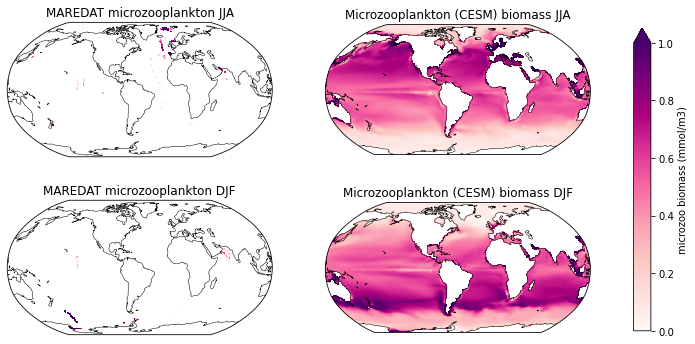

In [55]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT microzooplankton JJA', fontsize=12)
tmp = maredat_microzoo_ds.JJA_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_microzoo_ds.LONGITUDE, maredat_microzoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (CESM) biomass JJA', fontsize=12)
tmp = cesm_mon_ds.microzooC.isel(month=[5,6,7],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='month')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MAREDAT microzooplankton DJF', fontsize=12)
tmp = maredat_microzoo_ds.DJF_mean_top100m/12.011 #converting from mg/m3 to mmol/m3
pc=ax.pcolormesh(maredat_microzoo_ds.LONGITUDE, maredat_microzoo_ds.LATITUDE, tmp, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Microzooplankton (CESM) biomass DJF', fontsize=12)
tmp = cesm_mon_ds.microzooC.isel(month=[11,0,1],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='month')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='RdPu',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max',label='microzoo biomass (mmol/m3)');

### COPEPOD comparison (Mesozooplankton)

In [56]:
file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file)
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

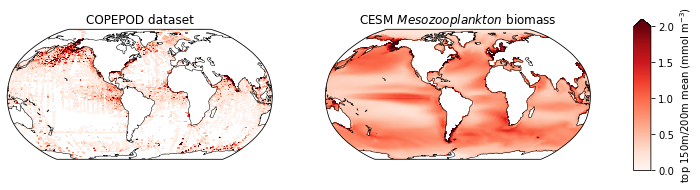

In [57]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('COPEPOD dataset', fontsize=12)
tmp = ds_copepod.copepod_C
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM ${\it Mesozooplankton}$ biomass', fontsize=12)
tmp = cesm_ann_ds.mesozooC.mean(dim='z_t_150m')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)')

### compare to spatially interpolated COPEPOD climatology
#### (dataset is in units of mgC/m2, despite its being labeled otherwise, personal communication with Colleen Petrik)

In [58]:
file = '/glade/u/home/kristenk/work/copepod-biomass/obsglmm_zmeso_vint_200m_monthly_climatology.nc'
ds_copepod_clim = xr.open_dataset(file)

In [59]:
ds_copepod_clim.zmeso200.attrs['units'] = 'mgC m-2'

### depth integrate CESM and convert to same units

In [60]:
### depth integrate and convert model to mol/m2
cesm_mon_ds['mesozooC_zint'] = ((cesm_mon_ds.mesozooC) * 10.).sum(dim='z_t_150m') #in mmol/m2

cesm_mon_ds['mesozooC_zint'] = cesm_mon_ds['mesozooC_zint'] * 12.011 #convert to mgC/m2
cesm_mon_ds['mesozooC_zint'].attrs['units'] = 'mgC m-2'

In [61]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

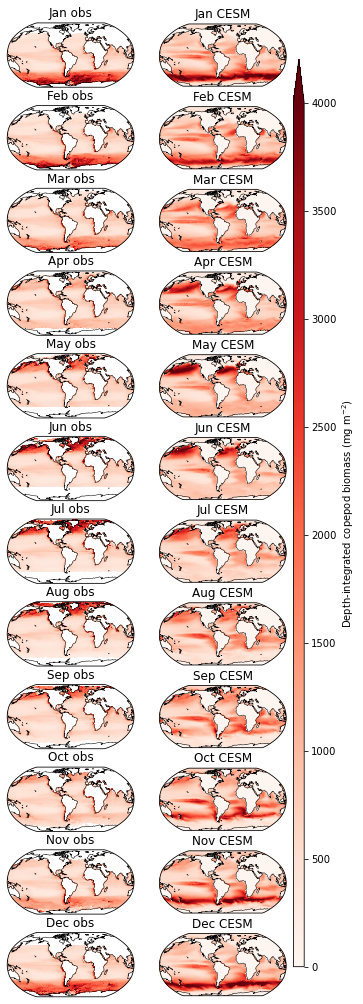

In [62]:
fig = plt.figure(figsize=(5,18))

for row in np.arange(1,13):
    
    ts=row-1
    
    plot = row*2 - 1
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' obs', fontsize=12)
    pc=ax.pcolormesh(ds_copepod_clim.Lon, ds_copepod_clim.Lat, ds_copepod_clim.zmeso200.isel(month=ts), 
                     cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
    plot = row*2
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts]+' CESM', fontsize=12)
    tmp = cesm_mon_ds.mesozooC_zint.isel(month=ts)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
    pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='Depth-integrated copepod biomass (mg m$^{-2}$)');

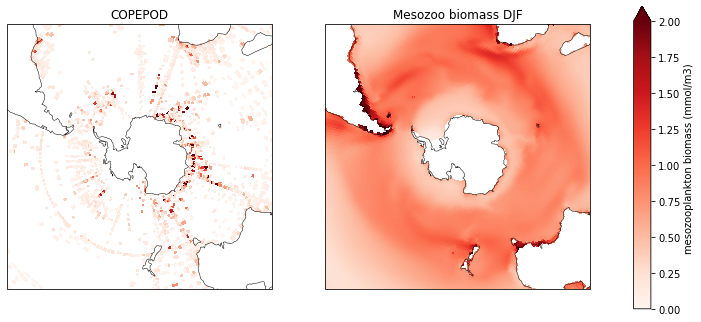

In [63]:
fig = plt.figure(figsize=(12,6))

# obs -----------------------------------------------------------------
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
ax.set_title('COPEPOD')
tmp = ds_copepod.copepod_C
lon,lat,field = utils.adjust_pop_grid(lons, lats, tmp)

sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]
pc=ax.pcolormesh(lons_sh, lats_sh, field, #converting from mg/m3 to mmol/m3
                 vmin=0, vmax=2, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())

########################
tmp = cesm_ann_ds.mesozooC.mean(dim='z_t_150m')
lon,lat,field = utils.adjust_pop_grid(lons, lats, tmp)

sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]


ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('Mesozoo biomass DJF', fontsize=12)
pc=ax.pcolormesh(lons_sh, lats_sh, 
                 field, 
                 vmin=0, vmax=2, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())


ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='mesozooplankton biomass (mmol/m3)');
# cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
# fig.colorbar(pci, cax=cbar_ax,extend='max', label='IFRAC');

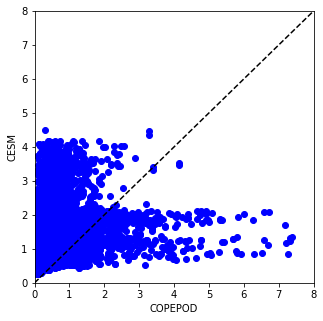

In [64]:
#### make line plots plotting mesozooplankton abundance versus COPEPOD database
one2one = np.array([0, 8])
x_vals = ds_copepod.copepod_C.values
x_vals = x_vals.flatten()

fig = plt.figure(figsize=(5,5))   
#set up the vals
y_vals = cesm_ann_ds.mesozooC.isel(z_t_150m=0).values
y_vals = y_vals.flatten()
ax = fig.add_subplot(1,1,1)
ax.scatter(x_vals,y_vals,color='blue',marker='o',
           label='control')
ax.set_ylabel('CESM')
ax.set_xlabel('COPEPOD')
ax.set_ylim(0,8)
ax.set_xlim(0,8)
ax.plot(one2one,one2one,color='black',linestyle='--')

### Calcification

In [65]:
## GLOBALLY integrated calcification; observation-based estimates range from 0.8 to 2.4 Pg CaCO3 per year 
## (Feely et al., 2004, Maranon et al., 2016, Smith et al., 2016, Balch et al., 2007, Iglesias-Rodriguez et al., 2002)
ds_glb['CaCO3_PROD_zint'] = esmlab.statistics.weighted_sum(cesm_ann_ds['CaCO3_PROD_zint'], weights=area, dim=['nlat', 'nlon'])
ds_glb['CaCO3_PROD_zint'] = ds_glb['CaCO3_PROD_zint'] * nmols_to_PgCyr
ds_glb['CaCO3_PROD_zint'].values
print('Globally integrated calcification is',np.round(ds_glb['CaCO3_PROD_zint'].values,4), 'Pg C per year')
print('(should be between 0.6 to 2.4 Pg C per year)')

Globally integrated calcification is 0.9352 Pg C per year
(should be between 0.6 to 2.4 Pg C per year)


In [66]:
#read in mean PIC
pic_file = '/glade/work/kristenk/satellite_data/processed/PIC_mean2003to2018_1deg.nc'
ds_pic=xr.open_dataset(pic_file, decode_times=False)

#convert to mmol/m3 from mg/m3
ds_pic['PIC']=ds_pic.PIC / 12.011

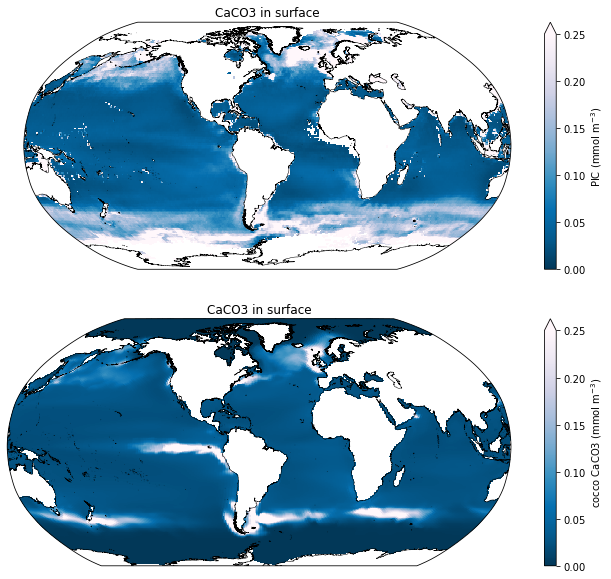

In [67]:
fig = plt.figure(figsize=(12,10))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_pic.lon.values, ds_pic.lat.values, ds_pic.PIC, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='PIC (mmol m$^{-3}$)')

ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.coccoCaCO3.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco CaCO3 (mmol m$^{-3}$)')


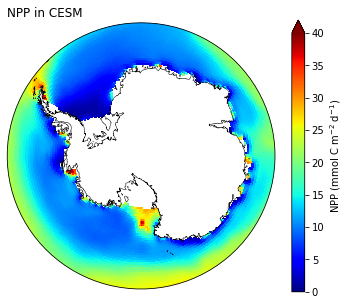

In [68]:
fig = plt.figure(figsize=(6,5))

import matplotlib.path as mpath
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('NPP in CESM', loc='left')
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('10m',linewidth=0.5)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.photoC_TOT_zint*86400*0.01)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=0, vmax=40, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='NPP (mmol C m$^{-2}$ d$^{-1}$)')

#fig.savefig('/glade/work/kristenk/figs/npp.png', bbox_inches='tight', dpi=300, format='png');

### cocco PIC/POC

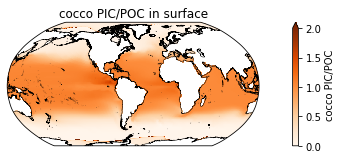

In [69]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('cocco PIC/POC in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.coccoCaCO3.isel(z_t_150m=0)/cesm_ann_ds.coccoC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='Oranges',vmin=0,vmax=2,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco PIC/POC')


### N fixation

In [70]:
#global integral
tmp = cesm_ann_ds['diaz_Nfix'] * 10. #multiply by the thickness of each layer in the top 150m (10m)
tmp = tmp.sum(dim='z_t_150m').where(cesm_ann_ds.photoC_TOT_zint>-100.) # unit is mmol/m2/s
ds_glb['diaz_Nfix'] = esmlab.statistics.weighted_sum(tmp, weights=area_m, dim=['nlat', 'nlon'])
ds_glb['diaz_Nfix'] = ds_glb['diaz_Nfix'] * 86400. * 365. * 0.001 * 14. * 1e-12 #convert to Tg N / yr
ds_glb['diaz_Nfix'].values
print('Globally integrated marine nitrogen fixation is',np.round(ds_glb['diaz_Nfix'].values,4), 'Tg N per year')
print('(should be between ~163.2 (range between 125.6 and 222.9 Tg N per year; Wang et al., 2019)')

Globally integrated marine nitrogen fixation is 194.0717 Tg N per year
(should be between ~163.2 (range between 125.6 and 222.9 Tg N per year; Wang et al., 2019)


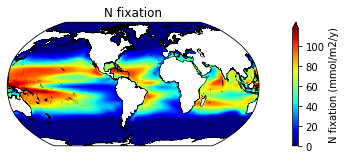

In [71]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('N fixation', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp*86400. * 365.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',
                 #vmin=0,vmax=2,
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='N fixation (mmol/m2/y)')


### Alkalinity

In [72]:
#just getting this for the coords (that don't have nans)
file = '/glade/work/kristenk/GLODAPv2_regridded/glodap_pop_grid/GLODAP_POPgrid_ALK_SALT.nc'
ds_glodap = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_glodap['z_t']=cesm_ann_ds.z_t

In [73]:
#rmse_global['ALK']=esmlab.statistics.weighted_rmsd(cesm_ann_ds.ALK, ds_glodap.ALK, dim=['nlat', 'nlon'], weights=area)

### Salinity normalized ALK
ds_glodap['sAlk'] = ds_glodap.ALK/ds_glodap.SALT * 35.

In [74]:
cesm_ann_ds['sAlk'] = cesm_ann_ds.ALK/cesm_ann_ds.SALT * 35

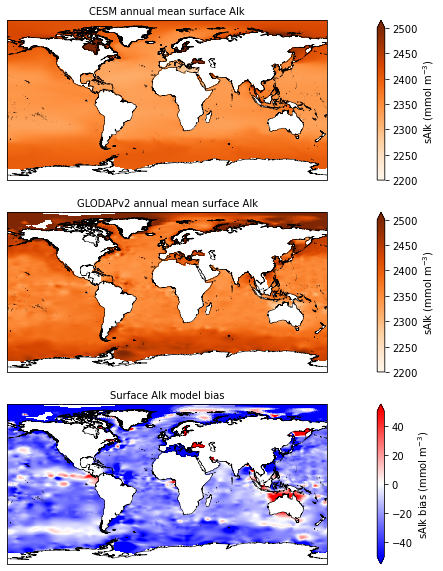

In [75]:
#plot surface alkalinity

fig = plt.figure(figsize=(18,10))

#---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface Alk', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.sAlk.isel(z_t=0))
pc1=ax.pcolormesh(lon, lat, 
                 field, cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='sAlk (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('GLODAPv2 annual mean surface Alk', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_glodap.sAlk.isel(z_t=0))
pc2=ax.pcolormesh(lon, lat, 
                 field, cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='sAlk (mmol m$^{-3}$)')

#---- DIFF panel
sALK_diff = cesm_ann_ds.sAlk - ds_glodap.sAlk

ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface Alk model bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  sALK_diff.isel(z_t=0))
pc3=ax.pcolormesh(lon, lat, 
                 field, vmin=-50, vmax=50, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='sAlk bias (mmol m$^{-3}$)')

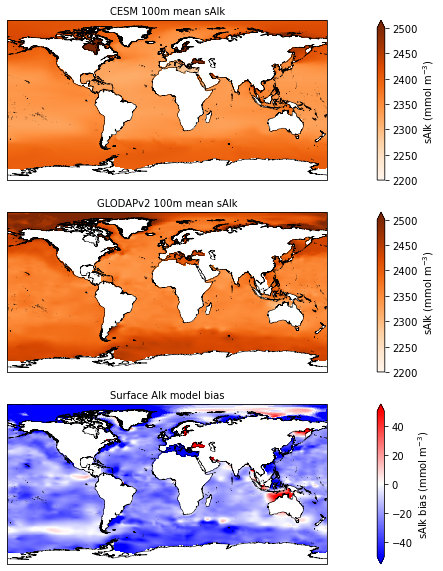

In [76]:
#plot surface alkalinity

fig = plt.figure(figsize=(18,10))

#---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM 100m mean sAlk', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds.sAlk.isel(z_t=slice(0,10)).mean(dim='z_t'))
pc1=ax.pcolormesh(lon, lat, 
                 field, cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='sAlk (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('GLODAPv2 100m mean sAlk', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_glodap.sAlk.isel(z_t=slice(0,10)).mean(dim='z_t'))
pc2=ax.pcolormesh(lon, lat, 
                 field, cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='sAlk (mmol m$^{-3}$)')

#---- DIFF panel
sALK_diff = cesm_ann_ds.sAlk - ds_glodap.sAlk

ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface Alk model bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  sALK_diff.isel(z_t=slice(0,10)).mean(dim='z_t'))
pc3=ax.pcolormesh(lon, lat, 
                 field, vmin=-50, vmax=50, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='sAlk bias (mmol m$^{-3}$)')

### Global POC export

In [77]:
ds_glb['POC_FLUX_100m'] = esmlab.statistics.weighted_sum(cesm_ann_ds['POC_FLUX_100m'], weights=area, dim=['nlat', 'nlon'])
ds_glb['POC_FLUX_100m'] = ds_glb['POC_FLUX_100m'] * nmols_to_PgCyr
ds_glb['POC_FLUX_100m'].values
print('Globally integrated POC flux is',ds_glb['POC_FLUX_100m'].values, 'Pg C per year')

Globally integrated POC flux is 6.970152924873432 Pg C per year


### Export ratio

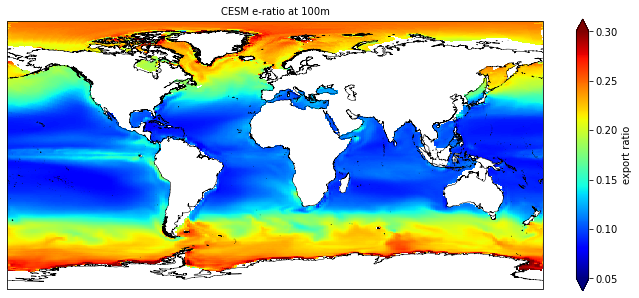

In [78]:
#plot E-RATIO
eratio = cesm_ann_ds.POC_FLUX_100m/cesm_ann_ds.photoC_TOT_zint_100m

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM e-ratio at 100m', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  eratio)
pc1=ax.pcolormesh(lon, lat, 
                 field, cmap='jet',
                  vmin=0.05, vmax=0.3, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='export ratio')


### Let's look at Fe

In [81]:
from dask_jobqueue import PBSCluster
import dask
from distributed import Client

def get_ClusterClient():
    cluster = PBSCluster(
        cores=1,
        memory='25GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(8) 
client

<Client: 'tcp://128.117.208.82:46497' processes=0 threads=0, memory=0 B>

In [82]:
nmolcm3_to_nM = 1e3
cesm_ann_ds['Fe'] = cesm_ann_ds['Fe'] * nmolcm3_to_nM
cesm_ann_ds['Fe'].attrs['units'] = 'nM'

In [83]:
# file = '/glade/work/kristenk/Fe_obs/Fe_obs_gx3v7.nc'
# Fe_obs = xr.open_dataset(file)
dFe_obs_file = '/glade/u/home/kristenk/cesm2-marbl/notebooks/discrete_obs/dFe-database-2021-05-20.csv'
df = pd.read_csv(dFe_obs_file, na_values=-999.).dropna(axis=0, how='all')

In [84]:
%%time

df.obs_stream.add_model_field(cesm_ann_ds.Fe)

CPU times: user 38 s, sys: 2.57 s, total: 40.6 s
Wall time: 4min 41s


In [85]:
df

lon      lat   depth   dFe_obs        Fe
0      210.010 -16.0018    20.0  0.540000  0.133463
1      210.010 -16.0018    35.0  0.440000  0.132632
2      210.010 -16.0019    50.0  0.480000  0.130649
3      210.010 -16.0019    80.0  0.400000  0.121696
4      210.010 -16.0020   100.0  0.390000  0.125453
...        ...      ...     ...       ...       ...
27777  160.051  47.0032  3929.6  0.825681  0.728897
27778  160.051  47.0032  3929.8  0.902248  0.728892
27779  160.051  47.0032  4900.4  0.555630       NaN
27780  160.051  47.0032  4900.9  0.621851       NaN
27781  160.051  47.0032  5210.1  0.573220       NaN

[27782 rows x 5 columns]

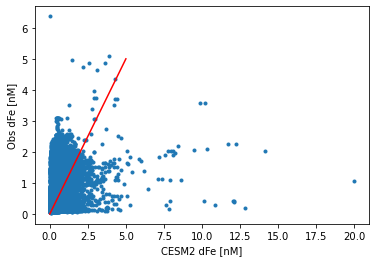

In [86]:
plt.plot(df.dFe_obs, df.Fe, '.')
plt.xlabel('CESM2 dFe [nM]')
plt.ylabel('Obs dFe [nM]')
plt.plot([0, 5], [0, 5], 'r-')

In [87]:
import plot
import matt_utils
import matplotlib.gridspec as gridspec

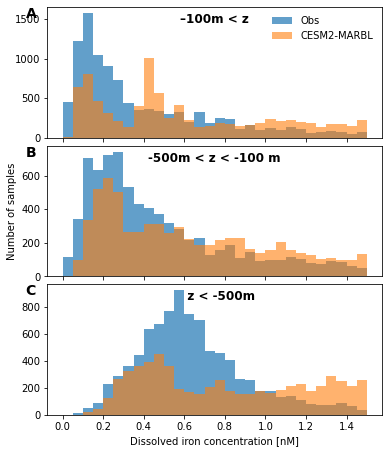

In [88]:
fig, axs = plot.canvas(3, 1, figsize=(6, 2.5), use_gridspec=True, hspace=0.06)

dx = 0.05
bin_edges = np.arange(0., 1.5+dx, dx)
bins = np.vstack((bin_edges[:-1], bin_edges[1:])).mean(axis=0)

depth_ranges = {
    '–100m < z': (0., 100.),
    '-500m < z < -100 m': (100., 500.),
    '   z < -500m': (500., 1e36),
}

for n, (key, depth_range) in enumerate(depth_ranges.items()):
    ax = axs[n, 0]
    df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
    
    hist, _ = np.histogram(df_sub.dFe_obs.values, bin_edges)
    ax.bar(bins, hist, width=dx, alpha=0.7, label='Obs')
    
    hist, _ = np.histogram(df_sub.Fe.values, bin_edges)
    ax.bar(bins, hist, width=dx, alpha=0.6, label='CESM2-MARBL')
    
    if n == 0:
        ax.legend(loc='upper right', frameon=False)
    if n < 2:
        ax.set_xticklabels([])
    ylm = ax.get_ylim()
    ax.text(0.75, ylm[1] - 0.12 * np.diff(ylm), key, 
            fontweight='bold',
            fontsize=12,
            ha='center',
           )
    if n == 1:
        ax.set_ylabel('Number of samples')
    if n == 2:
        ax.set_xlabel('Dissolved iron concentration [nM]')
        
matt_utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=-0.05, yoff=-0.02)               
#utils.savefig('iron-global-ocean-obs-PDF')

In [89]:
dsp = matt_utils.pop_add_cyclic(cesm_ann_ds)

In [90]:
from itertools import product
import cmocean
import matplotlib.colors as colors

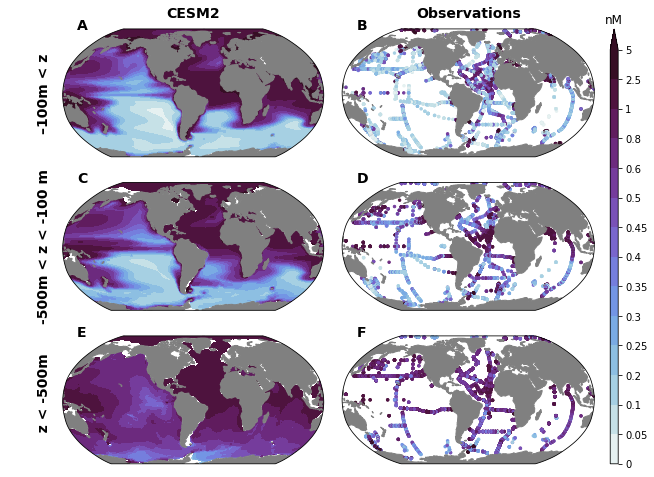

In [91]:
field = 'Fe'

levels = {'Fe': [0., 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8, 1., 2.5, 5.0]}


fig = plt.figure(figsize=(10, 8))
prj = ccrs.Robinson(central_longitude=305.0)

nrow, ncol = 3, 2 
gs = gridspec.GridSpec(
    nrows=nrow, ncols=ncol+1, 
    width_ratios=(1, 1, 0.03),
    wspace=0.05, 
    hspace=0.2,
)

axs = np.empty((nrow, ncol)).astype(object)
caxs= np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[i, j], projection=prj)
cax = plt.subplot(gs[:, -1])

cmap_field = cmocean.cm.dense


for i, (key, depth_range) in enumerate(depth_ranges.items()):
    for j in range(2):
        ax = axs[i, j]
        if j == 0:
            zslice = slice(depth_range[0]*100., depth_range[1]*100.)

            cf = ax.contourf(
                dsp.TLONG,dsp.TLAT, dsp[field].sel(z_t=zslice).mean('z_t'),
                levels=levels[field],
                extend='max',
                cmap=cmap_field,
                norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
                transform=ccrs.PlateCarree(),
            )
        else:
            df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
            sc = ax.scatter(
                df_sub.lon, df_sub.lat, c=df_sub.dFe_obs.values,
                cmap=cmap_field,
                norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
                s=6,
                transform=ccrs.PlateCarree(),
            )

        land = ax.add_feature(
            cartopy.feature.NaturalEarthFeature(
                'physical','land','110m',
                edgecolor='face',
                facecolor='gray'
            )
        )  

cb = plt.colorbar(cf, cax=cax, ticks=levels['Fe'])
if 'units' in dsp[field].attrs:
    cb.ax.set_title(dsp[field].attrs['units'])
    cb.ax.set_yticklabels([f'{f:g}' for f in levels['Fe']])

matt_utils.subplot_col_labels(axs[0, :], ['CESM2', 'Observations'])    
matt_utils.subplot_row_labels(axs[:, 0], depth_ranges.keys(), xoff=60)
    
matt_utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.02, yoff=0)       

In [92]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
